# Day 2 TP: Explainability Analysis with SHAP and LIME

**Course:** M2 SID - Processus Data 
**Instructor:** Feda Almuhisen 
**Year:** 2025-2026

---

## Objectives

In this notebook, you will:
- Apply **SHAP** (SHapley Additive exPlanations) for global and local feature importance
- Apply **LIME** (Local Interpretable Model-agnostic Explanations) for instance-level explanations
- Compare SHAP and LIME results
- Interpret ML predictions for non-technical stakeholders

---

## Prerequisites

Completed Day 1 TP (trained autoencoder model) 
Installed Day 2 dependencies: `pip install shap lime` 
Copied `explainability_utils.py` to `models/` folder

---

## Part 1: Setup and Imports

In [36]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import sys
from pathlib import Path

# Add project root to path
sys.path.append('..')

# Import from your Day 1 modules
from data.data_loader import load_processed_data
from data.preprocessing import TurbofanPreprocessor
from models.autoencoder import TurbofanAutoencoder

# Import Day 2 explainability utilities
from models import explainability_utils as exp_utils

# SHAP and LIME
import shap
from lime import lime_tabular

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print(" All libraries imported successfully!")

 All libraries imported successfully!


## Part 2: Load Data and Model from Day 1

In [37]:
# Load test data (same as Day 1)
print("Loading test data...")
_, _, test_df = load_processed_data('../data/processed/FD001')

# Preprocess (same as Day 1)
sensor_cols = [col for col in test_df.columns if col.startswith('sensor')]
X_test_raw = test_df[sensor_cols].values





2025-11-14 14:19:10,532 - INFO - Loading processed data from ..\data\processed\FD001...


Loading test data...


2025-11-14 14:19:10,834 - INFO -  Loaded data:
2025-11-14 14:19:10,835 - INFO -   Train: 16,561 samples
2025-11-14 14:19:10,836 - INFO -   Val:   4,070 samples
2025-11-14 14:19:10,838 - INFO -   Test:  13,096 samples


In [23]:
from data.data_loader import load_processed_data
from data.preprocessing import TurbofanPreprocessor

# Load test data already processed by the pipeline
print("Loading processed test data...")
_, _, test_df = load_processed_data('../data/processed/FD001')


# Select only sensor columns
sensor_cols = [c for c in test_df.columns if c.startswith('sensor_')]
X_test = test_df[sensor_cols].values

print("Test data shape:", X_test.shape)
print("Sensor columns:", sensor_cols)


2025-11-14 13:39:47,116 - INFO - Loading processed data from ..\data\processed\FD001...


Loading processed test data...


2025-11-14 13:39:47,341 - INFO -  Loaded data:
2025-11-14 13:39:47,343 - INFO -   Train: 16,561 samples
2025-11-14 13:39:47,344 - INFO -   Val:   4,070 samples
2025-11-14 13:39:47,346 - INFO -   Test:  13,096 samples


Test data shape: (13096, 18)
Sensor columns: ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_20', 'sensor_21']


In [47]:
# Load your trained model from Day 1
# UPDATE THIS PATH to match your model file!
model_path = "../models/autoencoder_pretrained.pth" # CHANGE THIS!

# Check available models
import glob
available_models = glob.glob("../models/*.pth")
print("Available models:")
for model in available_models:
    print(f" - {model}")

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = X_test_raw.shape[1]
encoding_dim = 16  # Match pretrained model architecture


model = TurbofanAutoencoder(input_dim=input_dim, encoding_dim=encoding_dim).to(device)
model.eval()

print(f"\n Model loaded from: {model_path}")
print(f"Device: {device}")



Available models:
 - ../models\autoencoder_pretrained.pth


2025-11-14 14:24:16,907 - INFO - Initialized TurbofanAutoencoder: 18→16→8→16



 Model loaded from: ../models/autoencoder_pretrained.pth
Device: cpu


## Part 3: Calculate Reconstruction Errors

First, let's calculate reconstruction errors for all test samples (same as Day 1).

In [51]:
# Calculate reconstruction errors
errors = exp_utils.calculate_reconstruction_error(model, X_test_raw, device)

print(f"Reconstruction errors calculated")
print(f" Mean: {errors.mean():.4f}")
print(f" Std: {errors.std():.4f}")
print(f" Min: {errors.min():.4f}")
print(f" Max: {errors.max():.4f}")

Reconstruction errors calculated
 Mean: 0.7499
 Std: 0.7082
 Min: 0.1357
 Max: 5.5133


In [52]:
# Detect anomalies
threshold, is_anomaly = exp_utils.detect_anomalies(errors, threshold_method="mean_plus_2std")

print(f"Anomaly threshold: {threshold:.4f}")
print(f"Anomalies detected: {is_anomaly.sum()} / {len(is_anomaly)} ({100*is_anomaly.sum()/len(is_anomaly):.2f}%)")

Anomaly threshold: 2.1664
Anomalies detected: 439 / 13096 (3.35%)


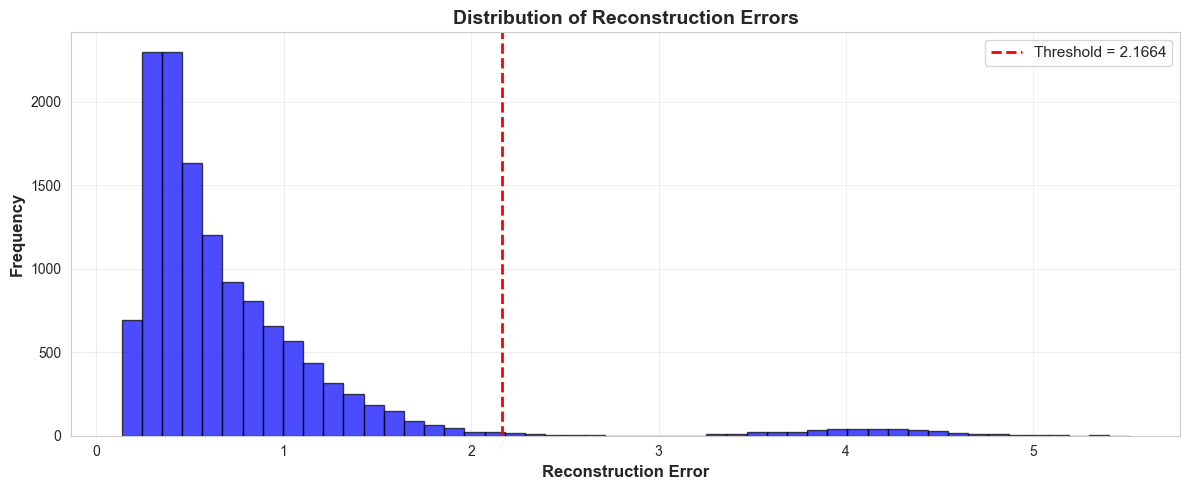

Blue region: Normal samples (error < 2.1664)
Right of red line: Anomalies (error > 2.1664)


In [53]:
# Visualize error distribution
plt.figure(figsize=(12, 5))
plt.hist(errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
plt.xlabel('Reconstruction Error', fontweight='bold', fontsize=12)
plt.ylabel('Frequency', fontweight='bold', fontsize=12)
plt.title('Distribution of Reconstruction Errors', fontweight='bold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Blue region: Normal samples (error < {threshold:.4f})")
print(f"Right of red line: Anomalies (error > {threshold:.4f})")

## Part 4: Select Samples for Analysis

We'll select:
- **1 normal sample** (low error)
- **1 anomaly sample** (high error)

We'll explain these samples using SHAP and LIME.

In [54]:
# Find normal and anomaly samples
normal_indices = np.where(~is_anomaly)[0]
anomaly_indices = np.where(is_anomaly)[0]

# Select one of each
normal_idx = normal_indices[100] # Pick 100th normal sample
anomaly_idx = anomaly_indices[10] if len(anomaly_indices) > 10 else anomaly_indices[0]

print(f"Selected samples:")
print(f" Normal sample: index {normal_idx}, error = {errors[normal_idx]:.4f}")
print(f" Anomaly sample: index {anomaly_idx}, error = {errors[anomaly_idx]:.4f}")

Selected samples:
 Normal sample: index 100, error = 0.2944
 Anomaly sample: index 906, error = 4.4423


## Part 5: Prepare for SHAP and LIME

Both SHAP and LIME need:
1. **Background data** (subset of training data)
2. **Prediction function** (model that takes X and returns error)

In [57]:
# Sample background data (100 random samples)
background_size = 100
background_indices = np.random.choice(len(X_test_raw), size=background_size, replace=False)
background_data = X_test_raw[background_indices]

print(f"Background data shape: {background_data.shape}")

Background data shape: (100, 18)


In [62]:
# Define prediction function
def predict_fn(X):
    """Wrapper function that returns reconstruction errors."""
    return exp_utils.calculate_reconstruction_error(model, X, device)

# Test prediction function
test_prediction = predict_fn(X_test_raw[:5])
print(f"Test predictions: {test_prediction}")
print(" Prediction function working")

Test predictions: [0.650332   1.0320696  0.5333742  0.70661426 0.92833203]
 Prediction function working


In [63]:
# Sample data to explain (20 random samples)
n_samples_to_explain = 20
sample_indices = np.random.choice(len(X_test_raw), size=n_samples_to_explain, replace=False)
X_explain = X_test_raw[sample_indices]

print(f"Sampled {n_samples_to_explain} instances to explain")

Sampled 20 instances to explain


---

## Part 6: TODO 1 - Setup SHAP Explainer

**Your task:** Complete the `create_shap_explainer()` function in `models/explainability_utils.py`

**Instructions:**
1. Open `models/explainability_utils.py`
2. Find the `create_shap_explainer()` function (line ~40)
3. Replace the `NotImplementedError` with:

```python
explainer = shap.KernelExplainer(predict_fn, background_data)
return explainer
```

**Then run the cell below to test:**

In [ ]:
# TODO 1: Setup SHAP explainer
try:
shap_explainer = exp_utils.create_shap_explainer(predict_fn, background_data)
print(" TODO 1 COMPLETE: SHAP explainer created successfully!")
except NotImplementedError as e:
print(f" TODO 1 NOT COMPLETE: {e}")
print("Please complete the create_shap_explainer() function in models/explainability_utils.py")

---

## Part 7: TODO 2 - Calculate SHAP Values

**Your task:** Complete the `calculate_shap_values()` function in `models/explainability_utils.py`

**Instructions:**
1. Open `models/explainability_utils.py`
2. Find the `calculate_shap_values()` function (line ~60)
3. Replace the `NotImplementedError` with:

```python
shap_values = explainer.shap_values(X, nsamples=nsamples)
return shap_values
```

**Note:** This may take 2-3 minutes to run!

In [ ]:
# TODO 2: Calculate SHAP values
try:
print("Calculating SHAP values... (this may take 2-3 minutes)")
shap_values = exp_utils.calculate_shap_values(shap_explainer, X_explain, nsamples=50)
print(f" TODO 2 COMPLETE: SHAP values calculated! Shape: {shap_values.shape}")
except NotImplementedError as e:
print(f" TODO 2 NOT COMPLETE: {e}")
print("Please complete the calculate_shap_values() function in models/explainability_utils.py")

### Visualize Global SHAP Importance

In [ ]:
# Global feature importance (mean absolute SHAP value)
if 'shap_values' in locals():
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Sort features by importance
sorted_indices = np.argsort(mean_abs_shap)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importance = mean_abs_shap[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importance, color='steelblue')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Mean |SHAP value|', fontweight='bold', fontsize=12)
plt.title('Global Feature Importance (SHAP)', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 5 most important sensors:")
for i in range(5):
print(f"{i+1}. {sorted_features[i]}: {sorted_importance[i]:.4f}")
else:
print(" Complete TODO 2 first!")

### SHAP Waterfall for Normal Sample

In [ ]:
# Find which explained sample corresponds to our normal sample
if 'shap_values' in locals():
# Find normal sample in explained samples
normal_shap_idx = np.where(sample_indices == normal_idx)[0]

if len(normal_shap_idx) > 0:
shap_normal = shap_values[normal_shap_idx[0]]
fig = exp_utils.plot_shap_waterfall(
shap_normal,
feature_names,
title=f"SHAP Waterfall - Normal Sample (error={errors[normal_idx]:.4f})"
)
plt.show()
else:
print("Normal sample not in explained samples. Re-run Part 4 to include it.")
else:
print(" Complete TODO 2 first!")

### Question 2.1

**What does a positive SHAP value mean for sensor_4 in the context of anomaly detection?**

*Write your answer here (double-click to edit):*

---

**Your answer:** 

---

### Question 2.2

**What does a negative SHAP value mean?**

*Write your answer here:*

---

**Your answer:** 

---

---

## Part 8: TODO 3 - Setup LIME Explainer

**Your task:** Complete the `create_lime_explainer()` function in `models/explainability_utils.py`

**Instructions:**
1. Open `models/explainability_utils.py`
2. Find the `create_lime_explainer()` function (line ~80)
3. Replace the `NotImplementedError` with:

```python
explainer = lime_tabular.LimeTabularExplainer(
training_data=background_data,
feature_names=feature_names,
mode=mode,
verbose=False
)
return explainer
```

In [ ]:
# TODO 3: Setup LIME explainer
try:
lime_explainer = exp_utils.create_lime_explainer(background_data, feature_names, mode='regression')
print(" TODO 3 COMPLETE: LIME explainer created successfully!")
except NotImplementedError as e:
print(f" TODO 3 NOT COMPLETE: {e}")
print("Please complete the create_lime_explainer() function in models/explainability_utils.py")

### Question 3.1

**Why does LIME use perturbations? What is it trying to learn?**

*Write your answer here:*

---

**Your answer:** 

---

---

## Part 9: TODO 4 - Generate LIME Explanations

**Your task:** Complete the `explain_instance_lime()` function in `models/explainability_utils.py`

**Instructions:**
1. Open `models/explainability_utils.py`
2. Find the `explain_instance_lime()` function (line ~100)
3. Replace the `NotImplementedError` with:

```python
explanation = explainer.explain_instance(
data_row=instance,
predict_fn=predict_fn,
num_features=num_features,
num_samples=num_samples
)
feature_weights = dict(explanation.as_list())
return explanation, feature_weights
```

In [ ]:
# TODO 4: Generate LIME explanation for normal sample
try:
print("Generating LIME explanation for normal sample...")
instance_normal = X_test_normalized[normal_idx]
lime_exp_normal, lime_weights_normal = exp_utils.explain_instance_lime(
lime_explainer,
instance_normal,
predict_fn,
num_features=14,
num_samples=500
)
print(f" TODO 4 COMPLETE: LIME explanation generated! Found {len(lime_weights_normal)} features")
except NotImplementedError as e:
print(f" TODO 4 NOT COMPLETE: {e}")
print("Please complete the explain_instance_lime() function in models/explainability_utils.py")

### Visualize LIME Weights for Normal Sample

In [ ]:
if 'lime_weights_normal' in locals():
fig = exp_utils.plot_lime_weights(
lime_weights_normal,
title=f"LIME Feature Weights - Normal Sample (error={errors[normal_idx]:.4f})"
)
plt.show()
else:
print(" Complete TODO 4 first!")

In [ ]:
# Generate LIME explanation for anomaly sample
if 'lime_explainer' in locals():
print("Generating LIME explanation for anomaly sample...")
instance_anomaly = X_test_normalized[anomaly_idx]
lime_exp_anomaly, lime_weights_anomaly = exp_utils.explain_instance_lime(
lime_explainer,
instance_anomaly,
predict_fn,
num_features=14,
num_samples=500
)
print(" LIME explanation for anomaly generated!")

# Plot
fig = exp_utils.plot_lime_weights(
lime_weights_anomaly,
title=f"LIME Feature Weights - Anomaly Sample (error={errors[anomaly_idx]:.4f})"
)
plt.show()
else:
print(" Complete TODO 3 first!")

---

## Part 10: TODO 5 - Compare SHAP vs LIME

**Your task:** Complete the `compare_shap_lime()` function in `models/explainability_utils.py`

**Instructions:**
1. Open `models/explainability_utils.py`
2. Find the `compare_shap_lime()` function (line ~130)
3. Replace the `NotImplementedError` with the comparison logic

**Hint:** Check sign agreement - features agree if both have same sign (both positive or both negative)

In [ ]:
# TODO 5: Compare SHAP vs LIME for normal sample
if 'shap_normal' in locals() and 'lime_weights_normal' in locals():
try:
agreement_rate_normal, disagreeing_features_normal = exp_utils.compare_shap_lime(
shap_normal,
lime_weights_normal,
feature_names
)
print(f" TODO 5 COMPLETE: SHAP-LIME Agreement (Normal): {agreement_rate_normal:.1%}")
if len(disagreeing_features_normal) > 0:
print(f"Disagreeing features: {disagreeing_features_normal}")
except NotImplementedError as e:
print(f" TODO 5 NOT COMPLETE: {e}")
print("Please complete the compare_shap_lime() function in models/explainability_utils.py")
else:
print(" Complete TODO 2 and TODO 4 first!")

### Visualize SHAP vs LIME Comparison

In [ ]:
if 'shap_normal' in locals() and 'lime_weights_normal' in locals():
fig = exp_utils.plot_shap_vs_lime(
shap_normal,
lime_weights_normal,
feature_names,
title="SHAP vs LIME - Normal Sample"
)
plt.show()
else:
print(" Complete TODO 2 and TODO 4 first!")

### Question 4.1

**If SHAP and LIME disagree on a feature, which one should you trust more? Why?**

*Write your answer here:*

---

**Your answer:** 

---

### Question 4.2

**What does high agreement (>80%) tell you about the model's predictions?**

*Write your answer here:*

---

**Your answer:** 

---

---

## Part 11: TODO 6 - Create Engineer-Friendly Interpretation

**Your task:** Complete the `interpret_for_engineer()` function in `models/explainability_utils.py`

**Instructions:**
1. Open `models/explainability_utils.py`
2. Find the `interpret_for_engineer()` function (line ~160)
3. Create a clear, actionable report for maintenance engineers

**Requirements:**
- Identify top 3 most important sensors
- Explain status (normal/anomaly)
- Provide actionable recommendations
- Use plain language (no technical jargon)

In [ ]:
# TODO 6: Create engineer interpretation for normal sample
if 'shap_normal' in locals():
try:
interpretation_normal = exp_utils.interpret_for_engineer(
shap_normal,
feature_names,
errors[normal_idx],
threshold,
errors[normal_idx] > threshold,
top_n=3
)
print(" TODO 6 COMPLETE: Engineer interpretation created!\n")
print(interpretation_normal)
except NotImplementedError as e:
print(f" TODO 6 NOT COMPLETE: {e}")
print("Please complete the interpret_for_engineer() function in models/explainability_utils.py")
else:
print(" Complete TODO 2 first!")

### Question 5.1

**How would you explain to a maintenance engineer (non-technical) why sensor_11 is important for detecting degradation?**

*Write your answer in plain language (2-3 sentences):*

---

**Your answer:** 

---

---

## Part 12: Summary Report

Generate a comprehensive summary of your explainability analysis.

In [ ]:
if 'shap_values' in locals():
exp_utils.print_summary_report(shap_values, feature_names, errors, threshold, is_anomaly)
else:
print(" Complete TODO 2 first to see summary report!")

---

## Deliverables

### What to Submit:

1. **Code:**
- Completed `models/explainability_utils.py` (all 6 TODOs filled)
- This notebook with all cells executed

2. **Answers:**
- Q2.1: Positive SHAP value meaning?
- Q2.2: Negative SHAP value meaning?
- Q3.1: Why LIME uses perturbations?
- Q4.1: SHAP vs LIME disagreement?
- Q4.2: High agreement interpretation?
- Q5.1: Explain sensor importance to engineer?



---

## Congratulations! 

You've completed Day 2 TP on Explainability!

**You now have a production-ready ML pipeline:**
- Day 1: Data exploration + Model training + MLflow tracking
- Day 2: Explainability with SHAP + LIME

**You learned:**
- How to apply SHAP for global and local explanations
- How to apply LIME for instance-level interpretability
- How to compare different explainability methods
- How to communicate ML results to non-technical stakeholders
- MLOps best practices (modular code, reusable utilities)

**Next steps:**
- Apply these techniques to your own ML projects
- Explore other XAI methods (Integrated Gradients, Attention, etc.)
- Deploy your model with explainability API

---

**Questions?** Contact: feda.almuhisen@univ-amu.fr